In [1]:
import asyncio
import itertools
import logging
import random
import nest_asyncio
import pandas as pd

nest_asyncio.apply()  #

In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union

from nuplan.planning.script.run_simulation import main as main_simulation

In [4]:
%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [5]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import (
    run_runners,
    set_default_path,
    set_up_common_builder,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv("NUPLAN_HYDRA_CONFIG_PATH", "config/simulation")

if os.environ.get("NUPLAN_HYDRA_CONFIG_PATH") is not None:
    CONFIG_PATH = os.path.join("../../../../", CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != "simulation":
    CONFIG_PATH = os.path.join(CONFIG_PATH, "simulation")
CONFIG_NAME = "default_simulation"

In [6]:
# list of selected scenario tokens
from tokens import selected_scenario_tokens, modifiable_scenario_tokens

print(selected_scenario_tokens[0:3])
print(modifiable_scenario_tokens[0:3])

selected_scenario_tokens = ["8b80aa05d88b518b"]

['d6234553edc95d50', '98ddd7851e445b7a', '5ac5795b9b5851e8']
['014c7f3502d4597d', '02828821ef045829', '02fa9b8d43465e0d']


In [7]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(
    os.getenv("NUPLAN_TUTORIAL_PATH", ""), "../nuplan/planning/script"
)
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

In [8]:
left_turn_types = [
    "stopping_at_crosswalk",
    "high_lateral_acceleration",
    "near_multiple_vehicles",
    "on_stopline_stop_sign",
    "near_long_vehicle",
    "unknown",
    "near_barrier_on_driveable",
    "near_high_speed_vehicle",
]
scenario_types = [
    "starting_left_turn",
    # "accelerating_at_traffic_light_with_lead",
    # "crossed_by_bike",
    # "crossed_by_vehicle",
    # "on_intersection",
    # "on_stopline_crosswalk",
    # "on_stopline_stop_sign",
    # "on_stopline_traffic_light",
    # "on_traffic_light_intersection",
    # "starting_protected_cross_turn",
    # "starting_protected_noncross_turn",
    "starting_right_turn",
    "starting_straight_stop_sign_intersection_traversal",
    "starting_straight_traffic_light_intersection_traversal",
    # "starting_u_turn",
    "starting_unprotected_cross_turn",
    "starting_unprotected_noncross_turn",
    # "stationary_at_crosswalk",
    # "stationary_at_traffic_light_with_lead",
    # "stationary_at_traffic_light_without_lead",
    # "traversing_crosswalk",
    "traversing_intersection",
    "traversing_traffic_light_intersection",
]

left_turn_potential = [
    "starting_left_turn",
    "starting_unprotected_cross_turn",
]

# scenario_types = ['stationary_at_traffic_light_without_lead']

# selected_scenario_tokens = ["4b95591c786b5558"]  # cross bug
selected_scenario_tokens = ["2b430abcf49554c7"]  # merge occlusion bug

scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
DATASET_PARAMS = [
    f"scenario_builder={scenario_builder}",
    "scenario_filter=all_scenarios",  # [all_scenarios, val14_split]
    f"scenario_filter.scenario_types={scenario_types}",  # there are 70 scenario types in the trainingset and 58 in the validation set including "unknown" which make up the majority
    "scenario_filter.ego_displacement_minimum_m=10",  # use scenarios where the ego vehicle moves at least 10m
    #    'scenario_filter.remove_invalid_goals=true',  # remove scenarios where the goal is not invalid
    # "scenario_filter.ego_start_speed_threshold=5",  # Exclusive threshold that the ego's speed must rise above (meters per second) for scenario to be kept
    #    'scenario_filter.stop_speed_threshold=10',  # Inclusive threshold that the ego's speed must fall below (meters per second) for scenario to be kept:
    "scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]",  # select multiple [sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]
    # "scenario_filter.limit_total_scenarios=0.05",  # use n total scenarios if int, or if float smaller than 1, use n as a fraction of total scenarios (changes sampling frequency, unchanged leaves the frequency at 20Hz)
    "scenario_filter.num_scenarios_per_type=10",  # use 10 scenarios per scenario type #bring this back to 25 for testing the cross bug
    f"scenario_filter.scenario_tokens={selected_scenario_tokens}",  # List of scenarios to include (token)
    #'scenario_filter.log_names=["2021.08.24.20.03.01_veh-45_01091_01622"]',  # specific scenrios to simulate
    # turn off if you are selecting scenarios manually. turn on for initial filtering (0.05 gives us 1 scenario per second)
]

In [9]:
urban_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt"
gc_pgp_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/gc_pgp_checkpoint.ckpt"
hybrid_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt"
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg_occ = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        # "model=gc_pgp_model",
        # "model.aggregator.pre_train=false",
        # "planner.ml_planner.model_config=${model}",
        # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
        # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
        # "+observation.model=gc_pgp_model",
        # "+observation.model.aggregator.pre_train=false",
        # "+observation.model_config=${model}",
        # f"+observation.checkpoint_path={gc_pgp_ckpt}",
        f"observation.planner_type=pdm_closed",
        # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
        f"observation.occlusion_cfg.occlusion=True",
        f"observation.occlusion_cfg.manager_type=wedge",
        f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
        f"+observation.occlusion_cfg.notice_threshold=1.0",
        "+modify_scenario_simulations=true",
        "+modifier_types=[merge-conflict-with-occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right,
        # oncoming-left-turn-and-occlusion-injection, conflict-and-occlusion-injection,
        # sequential-conflict-with-occlusion-injection, cross-conflict-with-occlusion-injection
        # merge-conflict-with-occlusion-injection, diverge-conflict-with-occlusion-injection]
        "+remove_other_agents=true",
        "+occlusion=true",
        "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
        "+occlusion.uncloak_reaction_time=1.5",  # 0.1
        "+occlusion.notice_threshold=1.0",  # 0.1
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
    ],
)

output_folder_occ = cfg_occ.output_dir
print('output_folder_occ = "' + output_folder_occ + '"')


# closed mixed for simulation
# "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
# "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
# # "model=gc_pgp_model",
# # "model.aggregator.pre_train=false",
# # "planner.ml_planner.model_config=${model}",
# # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
# # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
# # "+observation.model=gc_pgp_model",
# # "+observation.model.aggregator.pre_train=false",
# # "+observation.model_config=${model}",
# # f"+observation.checkpoint_path={gc_pgp_ckpt}",
# f"observation.planner_type=pdm_closed",
# # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
# f"observation.occlusion_cfg.occlusion=true",
# f"observation.occlusion_cfg.manager_type=wedge",
# f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
# f"+observation.occlusion_cfg.notice_threshold=1.0",
# "+modify_scenario_simulations=true",
# "+modifier_types=[occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right]
# "+occlusion=true",
# "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
# "+occlusion.uncloak_reaction_time=1.0",
# "+occlusion.notice_threshold=0.1",
# "worker=ray_distributed",  # [sequential, ray_distributed]
# "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
# *DATASET_PARAMS,


# "+simulation=open_loop_boxes",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
#         "planner=log_future_planner",  # [ml_planner, pdm_hybrid_planner, gc_pgp_planner, idm_planner, log_future_planner, simple_planner]
#         "ego_controller=perfect_tracking_controller",
#         "worker=ray_distributed",  # [sequential, ray_distributed]
#         "+occlusion=true",  # [true, false]
#         "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
#         "+occlusion.uncloak_reaction_time=1.5",
#         "+occlusion.notice_threshold=1.0",
#         # "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
#         *DATASET_PARAMS,

default_simulation
output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.02.23.50.15"


# Now we can run with the following

In [10]:
# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg_occ)

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2024-04-02 23:50:15,617 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-04-02 23:50:15,619 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-04-02 23:50:17,362	INFO worker.py:1636 -- Started a local Ray instance.


2024-04-02 23:50:18,214 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-04-02 23:50:18,215 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-04-02 23:50:18,215 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-04-02 23:50:18,215 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-04-02 23:50:18,215 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.02.23.50.15

2024-04-02 23:50:18,217 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]
(raylet) [2024-04-02 23:50:27,329 E 750166 750178] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-50-15_647999_749832 is over 95% full, available space: 303494897664; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-04-02 23:50:28,392 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:83}  Building metric engines...
2024-04-02 23:50:28,663 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:85}  Building metric engines...DONE
2024-04-02 23:50:28,664 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:89}  Building simulations from 76 scenarios...
2024-04-02 23:50:29,908 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:151}  Modyfing Scenarios...
1 0 are the number of cpus and gpus
2024-04-02 23:50:29,909 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:116}  Submitting 76 tasks!


2024-04-02 23:50:35,750	ERROR worker.py:408 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::wrapped_fn() (pid=750258, ip=129.97.228.41)
  File "/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/ray_execution.py", line 59, in wrapped_fn
    result = fn(*args, **kwargs)
  File "/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py", line 218, in modify_simulations
    modified_simulations = modifier.modify_scenario(simulation)
  File "/home/ehdykhne/nuplan-devkit/nuplan/planning/scenario_builder/scenario_modifier/merge_conflict_with_occlusion_injection_modifier.py", line 309, in modify_scenario
    return [all_modified_simulation_runners[0]]
IndexError: list index out of range


(wrapped_fn pid=750252) []


KeyboardInterrupt: 

(raylet) [2024-04-02 23:50:37,336 E 750166 750178] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-50-15_647999_749832 is over 95% full, available space: 303505887232; capacity: 16125711347712. Object creation will fail if spilling is required.
2024-04-02 23:50:40,375	ERROR worker.py:408 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::wrapped_fn() (pid=750267, ip=129.97.228.41)
  File "/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/ray_execution.py", line 59, in wrapped_fn
    result = fn(*args, **kwargs)
  File "/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py", line 218, in modify_simulations
    modified_simulations = modifier.modify_scenario(simulation)
  File "/home/ehdykhne/nuplan-devkit/nuplan/planning/scenario_builder/scenario_modifier/merge_conflict_with_occlusion_injection_modifier.py", line 309, in modify_scenario
    return [all_modified_simulation_runners[0]]
IndexError: list 

(wrapped_fn pid=750264) [] [repeated 15x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


# Now we set up the second running regime

In [ ]:
#########################################

path = output_folder_occ + "/metrics/"
file_path_1 = path + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path_1)
df = df.loc[df["number_of_ego_collisions_with_vehicles_stat_value"] != 0]
df = df["scenario_name"]


scenario_list = df.tolist()
print(f"+scenarios_to_check_in_alternate_regime={scenario_list}")

hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)
cfg_unocc = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        # "model=gc_pgp_model",
        # "model.aggregator.pre_train=false",
        # "planner.ml_planner.model_config=${model}",
        # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
        # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
        # "+observation.model=gc_pgp_model",
        # "+observation.model.aggregator.pre_train=false",
        # "+observation.model_config=${model}",
        # f"+observation.checkpoint_path={gc_pgp_ckpt}",
        f"observation.planner_type=pdm_closed",
        # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
        f"observation.occlusion_cfg.occlusion=false",
        "+modify_scenario_simulations=true",
        "+second_testing_round=true",
        f"+scenarios_to_check_in_alternate_regime={scenario_list}",
        "+modifier_types=[merge-conflict-with-occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right,
        # oncoming-left-turn-and-occlusion-injection, conflict-and-occlusion-injection,
        # sequential-conflict-with-occlusion-injection, cross-conflict-with-occlusion-injection
        # merge-conflict-with-occlusion-injection, diverge-conflict-with-occlusion-injection]
        "+remove_other_agents=true",
        "+occlusion=false",
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
    ],
)

output_folder_unocc = cfg_unocc.output_dir
print('output_folder_unocc = "' + output_folder_unocc + '"')

+scenarios_to_check_in_alternate_regime=['a33bac928f275fd5_merge_conflict_injection_and_occlusion_injection_2_5.0_48800', '4e5f13bdc96e552f_merge_conflict_injection_and_occlusion_injection_0_0.0_20318', '2b430abcf49554c7_merge_conflict_injection_and_occlusion_injection_0_0.0_64500', '8fa88217489e51f0_merge_conflict_injection_and_occlusion_injection_3_0.0_20188', '04f3724b7de95996_merge_conflict_injection_and_occlusion_injection_0_0.0_70086', '48440858b9055112_merge_conflict_injection_and_occlusion_injection_0_0.0_53001', 'fef8d90af3345bbe_merge_conflict_injection_and_occlusion_injection_6_5.0_69423', '47b74fe4791a52c0_merge_conflict_injection_and_occlusion_injection_6_0.0_20049', 'fef8d90af3345bbe_merge_conflict_injection_and_occlusion_injection_5_5.0_69423', 'a41ed0bc8aff506b_merge_conflict_injection_and_occlusion_injection_0_-5.0_53586', '261dcafcc1315a91_merge_conflict_injection_and_occlusion_injection_5_0.0_20289', '8dcea0d285ec54a6_merge_conflict_injection_and_occlusion_injection_

output_folder_unocc = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.02.23.19.45"


## Run Second Regime

In [ ]:
main_simulation(cfg_unocc)

Global seed set to 0


2024-04-02 23:19:45,094 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2024-04-02 23:19:45,117 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2024-04-02 23:19:45,299 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-04-02 23:19:45,300 WARNING {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:135}  Ray is running, we will shut it down before starting again!
2024-04-02 23:19:48,518 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-04-02 23:19:50,310	INFO worker.py:1636 -- Started a local Ray instance.


2024-04-02 23:19:51,099 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-04-02 23:19:51,100 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-04-02 23:19:51,100 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-04-02 23:19:51,100 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-04-02 23:19:51,100 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.02.23.19.45

2024-04-02 23:19:51,102 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]
(raylet) [2024-04-02 23:20:00,272 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 304167542784; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-04-02 23:20:01,567 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:83}  Building metric engines...
2024-04-02 23:20:01,696 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:85}  Building metric engines...DONE
2024-04-02 23:20:01,696 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:89}  Building simulations from 76 scenarios...
2024-04-02 23:20:02,614 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:151}  Modyfing Scenarios...
[
	'04f3724b7de95996',
	'09e3ad03693c59da',
	'0c308ff01686526d',
	'261dcafcc1315a91',
	'267ea35c58805705',
	'2b430abcf49554c7',
	'37ccb622d85d5088',
	'47b74fe4791a52c0',
	'48440858b9055112',
	'4e5f13bdc96e552f',
	'78085da6ae0e5615',
	'8b80aa05d88b518b',
	'8dcea0d285ec54a6',
	'8fa88217489e51f0',
	'a33bac928f275fd5',
	'a41ed0bc8aff506b',
	'b0c6b8d1e149576d',
	'ccf23a9288075b08',
	'd6e87233d7635cfb',
	'da

Ray objects:   0%|          | 0/43 [00:00<?, ?it/s](raylet) [2024-04-02 23:20:10,283 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 304167403520; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-02 23:20:20,291 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 304167313408; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-02 23:20:30,299 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 304167297024; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-02 23:20:40,307 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% ful

2024-04-02 23:22:56,501 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 43
2024-04-02 23:22:56,502 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-04-02 23:22:56,502 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-04-02 23:22:56,508 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.02.23.19.45/runner_report.parquet
2024-04-02 23:22:56,509 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:03:11 [HH:MM:SS]
2024-04-02 23:22:57,054 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:00 [HH:MM:SS]
2024-04-02 23:22:57,118 

## Prepare the nuBoard config

In [ ]:
# output_folder_alt = []
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28"
# )
# output_folder_alt.append(
#     "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48"
# )

In [ ]:
# import hydra
# scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
# output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.06.45"
# output_folder_unocc = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.55.22"
# output_folder_occ = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.03.05.19.32.17"
# )
# output_folder_unocc = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.03.05.20.12.11"
# )
# output_folder_occ = '../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.01.22.29.40'
# output_folder_unocc = '../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.02.00.15.36'
output_folder = [output_folder_occ, output_folder_unocc]

print(output_folder_occ)
print(output_folder_unocc)

CONFIG_PATH = "../nuplan/planning/script/config/nuboard"
CONFIG_NAME = "default_nuboard"

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(
    config_name=CONFIG_NAME,
    overrides=[
        f"scenario_builder={scenario_builder}",  # set the database (same as simulation) used to fetch data for visualization
        f"simulation_path={output_folder}",  # [output_folder, output_folder_alt] nuboard file path(s), if left empty the user can open the file inside nuBoard
    ],
)

../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.02.22.57.06
../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.02.23.19.45


In [ ]:
from ipynb.fs.full.result_visualization import plot_diff

%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

number_of_ego_collisions_with_vehicles_stat_value (top 25 differences)
positive diff
                                                                     scenario_name  difference                                     scenario_type_1
0    a33bac928f275fd5_merge_conflict_injection_and_occlusion_injection_2_5.0_48800           1               traversing_traffic_light_intersection
2    2b430abcf49554c7_merge_conflict_injection_and_occlusion_injection_0_0.0_64500           1                             traversing_intersection
4    04f3724b7de95996_merge_conflict_injection_and_occlusion_injection_0_0.0_70086           1  starting_straight_stop_sign_intersection_traversal
5    48440858b9055112_merge_conflict_injection_and_occlusion_injection_0_0.0_53001           1                                  starting_left_turn
6    fef8d90af3345bbe_merge_conflict_injection_and_occlusion_injection_6_5.0_69423           1                     starting_unprotected_cross_turn
7    47b74fe4791a52c0_merge_confl

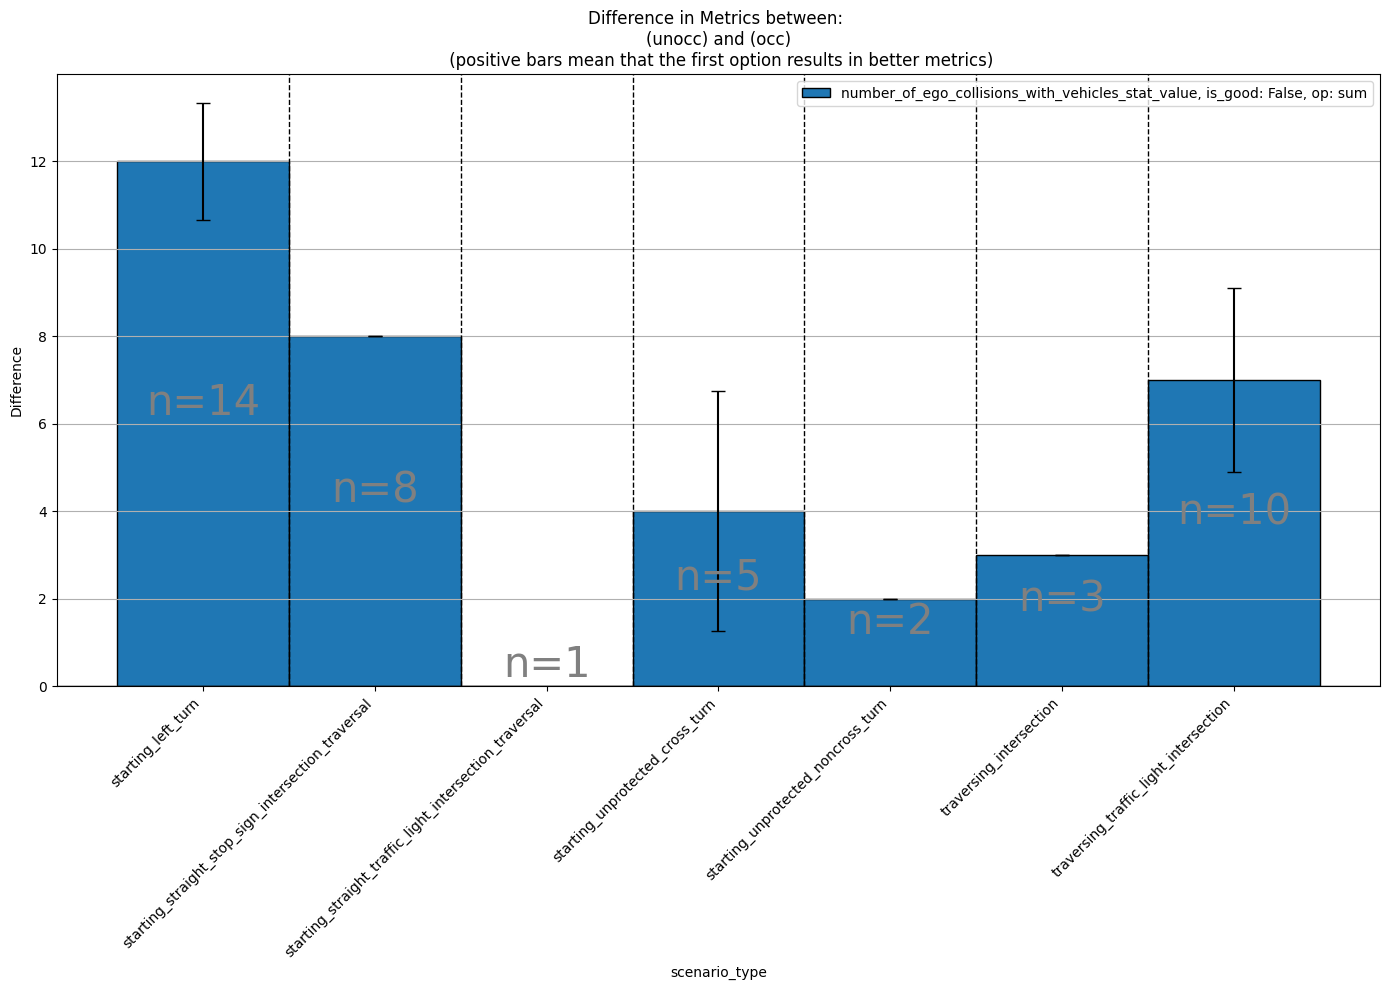

In [ ]:
file_path_1 = output_folder_unocc + "/metrics/" + "no_ego_at_fault_collisions.parquet"
file_path_2 = output_folder_occ + "/metrics/" + "no_ego_at_fault_collisions.parquet"


metrics = [
    "number_of_ego_collisions_with_vehicles_stat_value",
]
metric_op = [
    "sum",
]
# metrics are 'good' if you would like to succeed at them. ex: amount of crashes is bad, amount of money is good
good_metric = [
    False,
]

plot_diff(
    file_path_1,
    file_path_2,
    "unocc",
    "occ",
    metrics,
    metric_op,
    good_metric,
    group_by="scenario_type",
    k_differences=25,
    as_bool=True,
)

## Launch nuBoard (open in new tab - recommended)


In [ ]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2024-04-02 23:23:02,135 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2024-04-02 23:23:02,153 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2024-04-02 23:23:02,154 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2024-04-02 23:23:02,154 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2024-04-02 23:23:02,154 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
2024-04-02 23:23:02,154 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possib

(raylet) [2024-04-02 23:23:10,417 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303508332544; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-02 23:23:20,422 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303508328448; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-02 23:23:30,427 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303508328448; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-02 23:23:40,432 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303508324352; capacity: 1612571

2024-04-02 23:23:53,283 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2024-04-02 23:23:53,388 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0029 seconds.


INFO:tornado.access:200 GET / (127.0.0.1) 512.65ms


2024-04-02 23:23:53,490 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 512.65ms


INFO:tornado.access:101 GET /ws (127.0.0.1) 0.52ms


2024-04-02 23:23:54,493 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.52ms
2024-04-02 23:23:54,493 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2024-04-02 23:23:54,493 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created
2024-04-02 23:23:54,888 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2024-04-02 23:23:54,993 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0032 seconds.


INFO:tornado.access:200 GET / (127.0.0.1) 494.01ms


2024-04-02 23:23:55,096 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 494.01ms


(raylet) [2024-04-02 23:24:00,442 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303508267008; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-02 23:24:10,447 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303508262912; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-02 23:24:20,452 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303508262912; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-02 23:24:30,457 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303508258816; capacity: 1612571

2024-04-02 23:26:01,121 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 6.4408 seconds.


(raylet) [2024-04-02 23:26:10,508 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303507996672; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-02 23:26:20,512 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303507992576; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-02 23:26:30,517 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303507988480; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-02 23:26:40,523 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303507988480; capacity: 1612571

2024-04-02 23:31:31,578 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 12.6920 seconds.


(raylet) [2024-04-02 23:31:40,675 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303507251200; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-02 23:31:50,680 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303507222528; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-02 23:32:00,685 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303507218432; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-02 23:32:10,690 E 741044 741056] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-02_23-19-48_546364_734573 is over 95% full, available space: 303507210240; capacity: 1612571

KeyboardInterrupt: 